# Search: Solving a Maze Using a Goal-based Agent


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation,
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.


## Introduction

The agent has a map of the maze it is in (i.e., the environment is deterministic, discrete, and known). The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  

This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent can just follow the path and does not need percepts. The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree and the goal is to traverse all nodes. We are interested in dynamically creating a search tree with the aim of finding a good/the best path to the goal state. Follow the pseudo code presented in the text book closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Here is the small example maze:

In [1]:
f = open("small_maze.txt", "r")
maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore search may not form proper trees unless cycles are prevented. You need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the file [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation.

In [2]:
%run maze_helper.py

maze = parse_maze(maze_str)

# look at two positions in the maze
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)`
print("Position(8,1):", look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


Visualize the maze

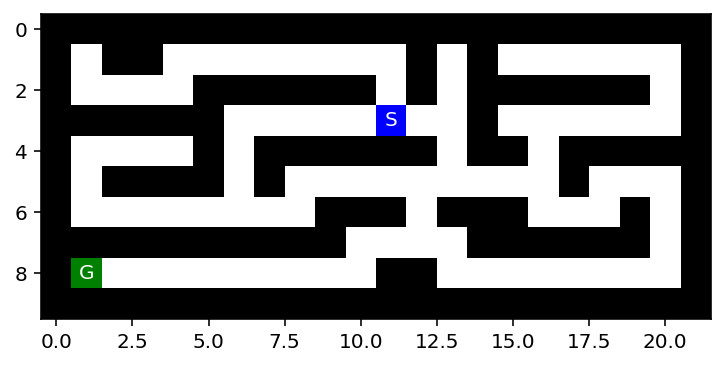

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [4]:
print("Start location:", find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


## Tree structure

Implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73):

In [5]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}"

Example: Create the root node and append the node for going east with a cost of 1.

In [6]:
print("Create root node")
root = Node(pos = (0,0), parent = None, action = None, cost = 0)
print("root:", root)
print("root (reference):", repr(root))

print()
print("Go east with cost 1 (from the parent root)")
node2 = Node(pos = (0,1), parent = root, action = "E", cost = 1)
print("node2:", node2)
print("parent of node2: ", node2.parent)
print("parent of node2 (reference): ", repr(node2.parent))

print()
print("Note that the root note is safe from garbage collection as long as we have a reference in node2") 
root = None
print(root)
print("parent of node2 (reference): ", repr(node2.parent))

print()
print("Once we release node2, the whole tree is deleted.")
node2 = None

Create root node
root: Node - pos = (0, 0); parent = None; action = None; cost = 0
root (reference): <__main__.Node object at 0x0000024AFBDCE970>

Go east with cost 1 (from the parent root)
node2: Node - pos = (0, 1); parent = <__main__.Node object at 0x0000024AFBDCE970>; action = E; cost = 1
parent of node2:  Node - pos = (0, 0); parent = None; action = None; cost = 0
parent of node2 (reference):  <__main__.Node object at 0x0000024AFBDCE970>

Note that the root note is safe from garbage collection as long as we have a reference in node2
None
parent of node2 (reference):  <__main__.Node object at 0x0000024AFBDCE970>

Once we release node2, the whole tree is deleted.


# Goal
Implement the following search algorithms for solving different mazes:

* Breadth-first search (BFS)
* Depth-first search (DFS)
* Iterative deepening search (IDS)
* Greedy best-first search (GBFS)
* A* search

Run each of the above algorithms on the 
[small maze](small_maze.txt), 
[medium maze](medium_maze.txt), 
[large maze](large_maze.txt), 
[open maze](open_maze.txt),
[wall maze](wall_maze.txt),
[loops maze](loops_maze.txt),
[empty maze](empty_maze.txt), and
[empty 2_maze](empty_2_maze.txt).
For each problem instance and each search algorithm, report the following in a table:

* The solution and its path cost
* Number of nodes expanded
* Maximum tree depth searched
* Maximum size of the frontier.

Display each solution by marking every maze square (or state) visited and the squares on the final path.

<hr>

## Task 1: Defining the search Problem [1 point]

Define the components of the search problem:

1) Initial state: The initial state is the state the agent starts in (Russel 64). For this search problem, the initial state is the start of the maze: space "S". We can find the coordiantes of the start space by running the command " <i>find_pos(maze, what = "S")</i>. " The coordiantes of the start space are (3, 11).

2) Actions: Given a state <i>s</i>, actions(s) are the finite set of options that can be executed in state "s".(Russel 64). In terms of this search problem, the only action is to move to a new position or the goal position (not a space with an X). The actions for the starting state can be modeled as follows: <br> <ul> <li> <i> actions(3,11) = { (4,11), (5,11) (3,12) } </i> (actions are move left, right, and up) </li> </ul>
3) Transition model: A transition model is a way to describe what each action does. In other words, transition models maps a state and action to a resulting state. One way of modeling this transition model, would be using the notation: <i>Result(s,a)</i>, where the result is returned for performing action, <i>a</i>, in the state, <i>s</i>. For this search problem, an example transition model:  <ul><li><i>Result[ (3,11), left) ] == (3,10)</i></li> </ul>
4) Goal state: The goal state is the desired state of the agent. For this search problem, the goal state is the end of the maze, and the space labeled "G". We can find the coordiantes of the goal space by running the command " <i>find_pos(maze, what = "G")</i>. " The coordiantes of the goal space are (8, 1).

5) Path cost: Sometimes called action cost, path cost is generally the weighted edge of a graph, and is the associated cost/score of moving from one state to another state (usually getting closer to the goal state). In terms of this maze search problem, the path cost is always equal to 1. In other words, the shortest route out of the maze (the optimal solution) will have the best path cost. 

In [7]:
#Start and Goal Coordinates:
print('Start location:', find_pos(maze, what = "S"))
print("Goal location:", find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


## Task 2: Breadth-first and Depth-first [4 points]

Implement these search strategies. Note that the algorithms for BFS and DFS are very different! Make sure that DFS uses less memory by releasing nodes that are not needed anymore. 

# BFS implementation:

In [8]:
from collections import deque

max_frontier_size = 0
max_tree_depth = 0
num_nodes_expanded = 0
visited = []

class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}"

#helper function returning list of valid potential child nodes:
def getChildNodes(myNode, myMaze, frontier):
    childList = []
    #pass in a node, and return a list of a valid child arrays
    lookPos_1 = myNode.pos[0] + 1, myNode.pos[1]
    lookPos_2 = myNode.pos[0] - 1, myNode.pos[1]
    lookPos_3 = myNode.pos[0], myNode.pos[1] - 1
    lookPos_4 = myNode.pos[0], myNode.pos[1] + 1
    #look at all potential spaces
    if look(myMaze, lookPos_1) != 'X' and not lookPos_1 in frontier:
        newChild = Node(pos = lookPos_1, parent = myNode, action = "E", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_2) != 'X' and not lookPos_2 in frontier:
        newChild = Node(pos = lookPos_2, parent = myNode, action = "W", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_3) != 'X' and not lookPos_3 in frontier:
        newChild = Node(pos = lookPos_3, parent = myNode, action = "N", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_4) != 'X' and not lookPos_4 in frontier:
        newChild = Node(pos = lookPos_4, parent = myNode, action = "S", cost = myNode.cost + 1)
        childList.append(newChild)
    #return the actual child list
    return childList

#BEGIN BFS:
def myBFS(maze, root):
    #---start stat keeping
    global max_frontier_size
    global max_tree_depth
    global num_nodes_expanded
    max_frontier_size = 0
    max_tree_depth = 0
    num_nodes_expanded = 0
    #---end stat keeping
    q = deque() #frontier as a queue
    global visited
    visited = []
    q.append(root) #queue intilization
    #actual BFS:
    while ( len(q) > 0 ): #while frontier/stack is not empty
        currNode = q.popleft() #node -> pop(frontier)
        visited.append(currNode.pos) #updated reached
        childList = getChildNodes(currNode, maze, visited) #
        
        #------ BEGIN STAT KEEPING -----
        num_nodes_expanded = num_nodes_expanded + 1
        if currNode.cost > max_tree_depth:
            max_tree_depth = currNode.cost
        if len(q) > max_frontier_size:
            max_frontier_size = len(q)
        #------- END STAT KEEPING -------
        
        for i in childList:
            currChild = i
            if look(maze, currChild.pos) == 'G':
                #print('found')
                return currChild
            #print(i)
            if not (currChild.pos in visited):
                q.append(currChild)
                visited.append(currChild.pos)
    print('failure')
    return root

small_maze.txt :
Solution Node:  Node - pos = (8, 1); parent = <__main__.Node object at 0x0000024AFCB2DC10>; action = N; cost = 19


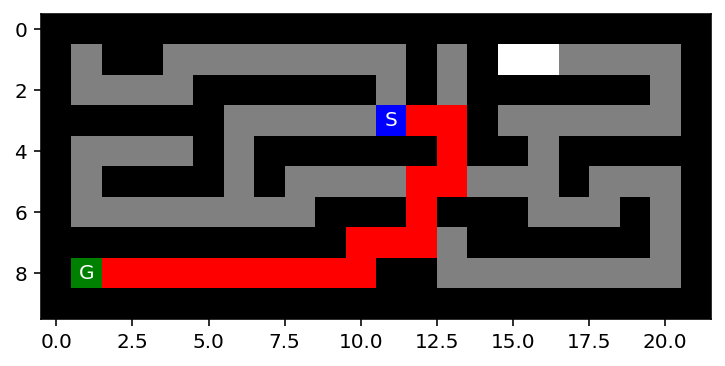

medium_maze.txt :
Solution Node:  Node - pos = (16, 1); parent = <__main__.Node object at 0x0000024AFCB74880>; action = N; cost = 68


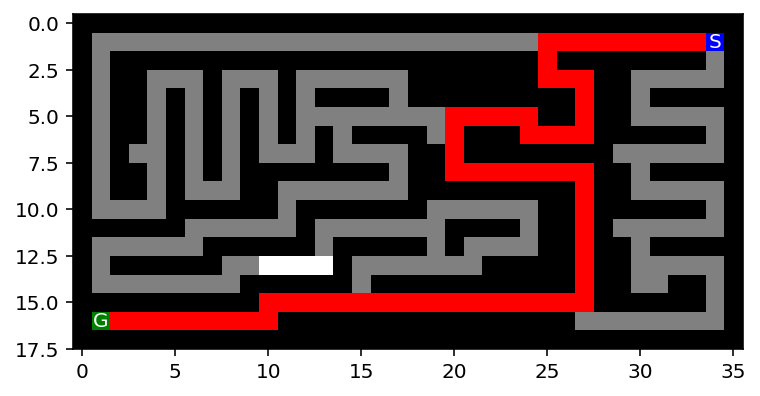

large_maze.txt :
Solution Node:  Node - pos = (35, 1); parent = <__main__.Node object at 0x0000024AFCBE8820>; action = E; cost = 210


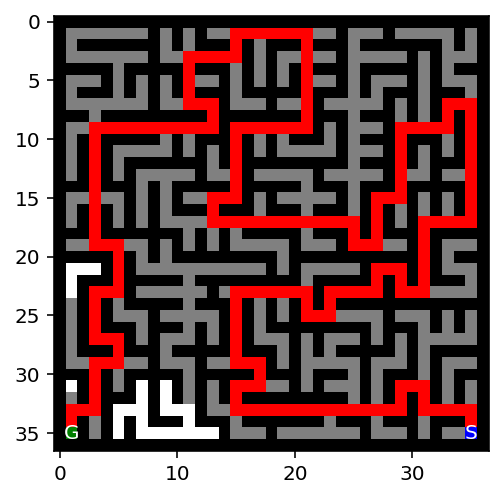

open_maze.txt :
Solution Node:  Node - pos = (21, 1); parent = <__main__.Node object at 0x0000024AFCDAF220>; action = N; cost = 54


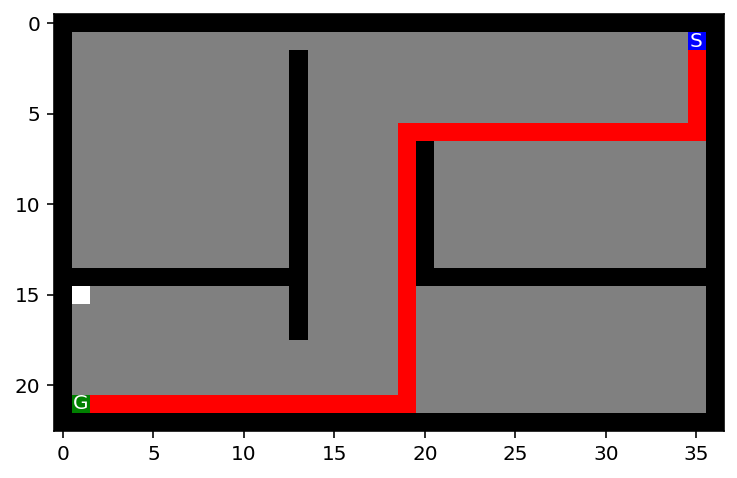

wall_maze.txt :
Solution Node:  Node - pos = (2, 9); parent = <__main__.Node object at 0x0000024AE8C30A60>; action = S; cost = 14


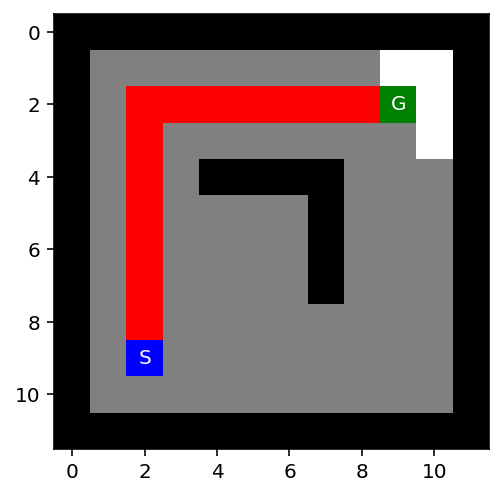

loops_maze.txt :
Solution Node:  Node - pos = (1, 1); parent = <__main__.Node object at 0x0000024AFCEFFCD0>; action = N; cost = 23


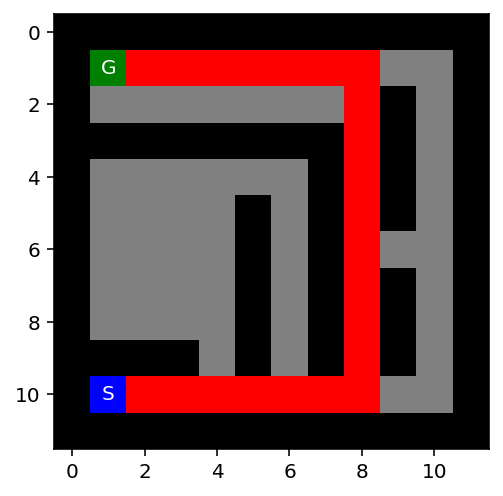

empty_maze.txt :
Solution Node:  Node - pos = (2, 9); parent = <__main__.Node object at 0x0000024AFCBCF400>; action = S; cost = 14


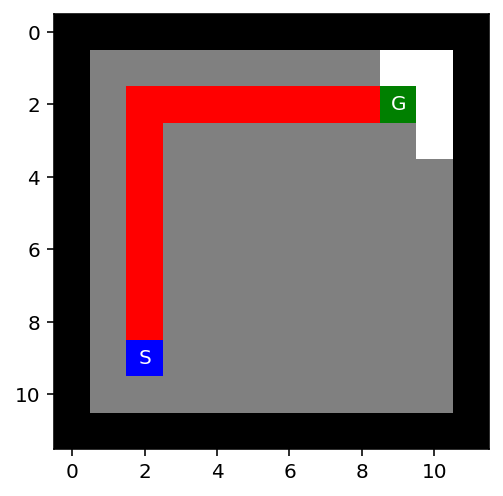

empty_2_maze.txt :
Solution Node:  Node - pos = (9, 2); parent = <__main__.Node object at 0x0000024AE8BAC7F0>; action = N; cost = 14


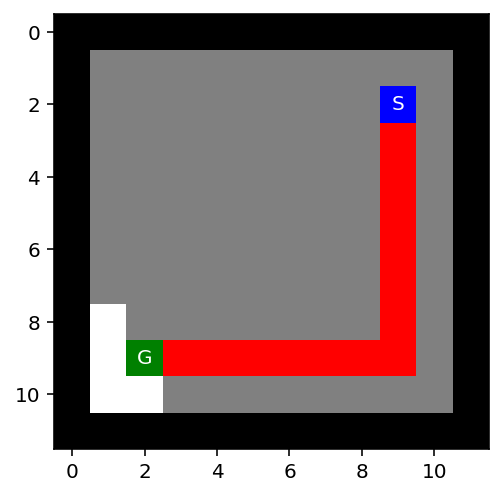

In [9]:
import pandas as pd
#use pandas to dispaly as table
col_names=['FileName', 'Path Cost', 'Max Frontier Size', 'Num Nodes Visited', 'Max Tree depth']
data_out = []
df = pd.DataFrame(data_out, columns=col_names)
fileNames = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
verbose = True

#do BFS
for i in fileNames:
    #parse maze:
    f = open(i, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    #perform DFS and get stats:
    start_pos = find_pos(maze, what="S")
    root = Node(pos=start_pos, parent=None, action=None, cost=0)  # make root node
    #---- BEGIN SEARCH -----
    goalNode_curr = myBFS(maze, root)
    #---- END SEARCH ----- result stored in goal node
    max_frontier_curr = max_frontier_size
    num_nodes_curr = num_nodes_expanded
    max_tree_depth_curr = max_tree_depth
    #get final path
    myList = []
    temp = goalNode_curr
    while temp != root:
        myList.append(temp.pos)
        temp = temp.parent
    #update maze for displaying
    for x in myList:
        maze[x[0]][x[1]] = "P"
    for x in visited:
        if(x not in myList):
            maze[x[0]][x[1]] = "."
    maze[goalNode_curr.pos[0]][goalNode_curr.pos[1]] = "G"
    maze[start_pos[0]][start_pos[1]] = "S"

    #ouptut solution data:
    fileName = i
    if verbose:
        print(fileName, ':')
        print('Solution Node: ', goalNode_curr)
        show_maze(maze)
    
    #append data to the pandas dataframe
    data = [fileName, goalNode_curr.cost, max_frontier_curr, num_nodes_curr, max_tree_depth_curr]
    df.loc[len(df.index)] = data

BFS_df = df

In [10]:
BFS_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,small_maze.txt,19,7,90,18
1,medium_maze.txt,68,7,267,67
2,large_maze.txt,210,7,616,209
3,open_maze.txt,54,24,679,53
4,wall_maze.txt,14,10,85,13
5,loops_maze.txt,23,7,70,22
6,empty_maze.txt,14,11,92,13
7,empty_2_maze.txt,14,11,92,13


<hr> <br>

# DFS implementation

In [11]:
max_frontier_size = 0
max_tree_depth = 0
num_nodes_expanded = 0
visited = []

class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}"

#helper function returning list of valid potential child nodes:
def getChildNodes(myNode, myMaze, frontier):
    childList = []
    #pass in a node, and return a list of a valid child arrays
    lookPos_1 = myNode.pos[0] + 1, myNode.pos[1]
    lookPos_2 = myNode.pos[0] - 1, myNode.pos[1]
    lookPos_3 = myNode.pos[0], myNode.pos[1] - 1
    lookPos_4 = myNode.pos[0], myNode.pos[1] + 1
    #look at all potential spaces
    if look(myMaze, lookPos_1) != 'X' and not lookPos_1 in frontier:
        newChild = Node(pos = lookPos_1, parent = myNode, action = "E", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_2) != 'X' and not lookPos_2 in frontier:
        newChild = Node(pos = lookPos_2, parent = myNode, action = "W", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_3) != 'X' and not lookPos_3 in frontier:
        newChild = Node(pos = lookPos_3, parent = myNode, action = "N", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_4) != 'X' and not lookPos_4 in frontier:
        newChild = Node(pos = lookPos_4, parent = myNode, action = "S", cost = myNode.cost + 1)
        childList.append(newChild)
    #return the actual child list
    return childList


#DFS
def myDFS(maze, root):
    #variable intilization:
    global max_frontier_size
    global max_tree_depth
    global num_nodes_expanded
    max_frontier_size = 0
    max_tree_depth = 0
    num_nodes_expanded = 0
    stack = []
    global visited
    visited = []
    stack.append(root) #stack intilization
    currNode = root
    #actual DFS:
    while ( len(stack) > 0 ): #while frontier/stack is not empty
        prevNode = currNode
        currNode = stack.pop()
        
        #------ BEGIN STAT KEEPING -----
        num_nodes_expanded = num_nodes_expanded + 1
        if currNode.cost < prevNode.cost: #DFS USES LESS MEMORY BY RELEASING NODES NOT NEEDED ANYMORE
            prevNode = None
        visited.append(currNode.pos)
        if currNode.cost > max_tree_depth:
            max_tree_depth = currNode.cost
        if len(stack) > max_frontier_size:
            max_frontier_size = len(stack)
        #------- END STAT KEEPING -------
        if look(maze, currNode.pos) == 'G': #GOAL STATE FOUND
            #print('found')
            return currNode
        #looking at potential children children nodes
        childList = getChildNodes(currNode, maze, visited)
        for i in childList:
            #print(i)
            if not (i in stack):
                stack.append(i)
    print('failure')
    return root


small_maze.txt :
Solution Node:  Node - pos = (8, 1); parent = <__main__.Node object at 0x0000024AFCDCE640>; action = N; cost = 37


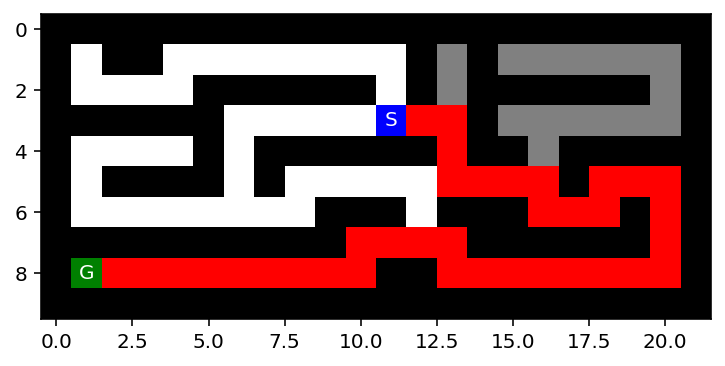

medium_maze.txt :
Solution Node:  Node - pos = (16, 1); parent = <__main__.Node object at 0x0000024AFCF477C0>; action = N; cost = 130


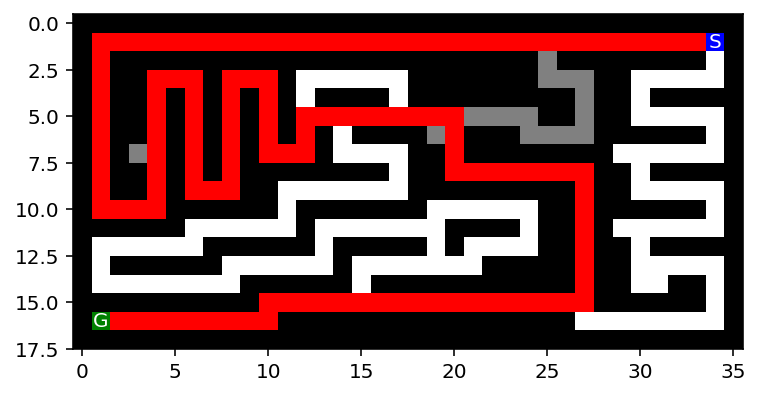

large_maze.txt :
Solution Node:  Node - pos = (35, 1); parent = <__main__.Node object at 0x0000024AFCC637F0>; action = E; cost = 210


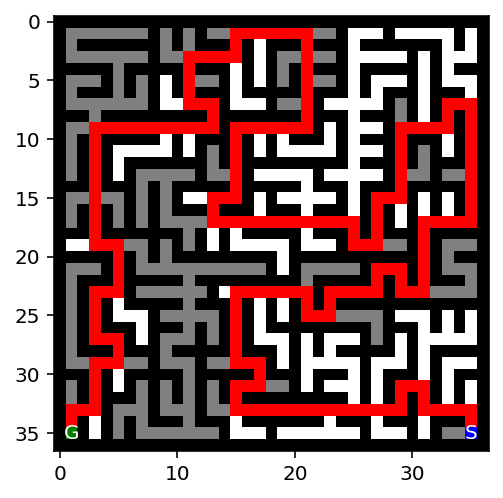

open_maze.txt :
Solution Node:  Node - pos = (21, 1); parent = <__main__.Node object at 0x0000024AFCCE7D30>; action = E; cost = 330


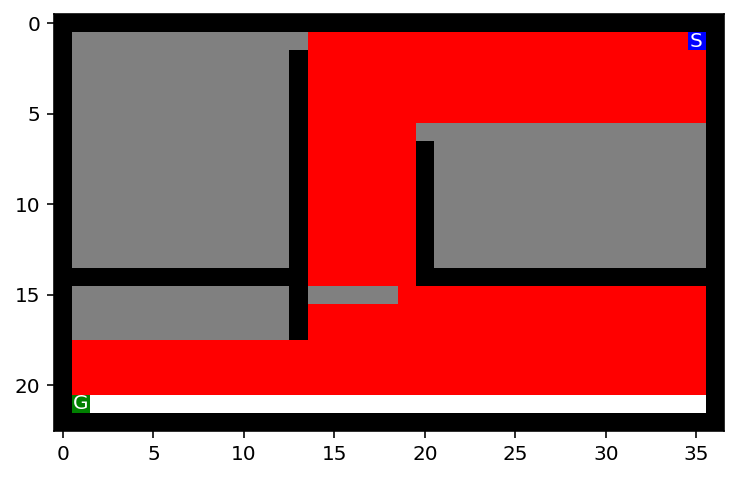

wall_maze.txt :
Solution Node:  Node - pos = (2, 9); parent = <__main__.Node object at 0x0000024AFCCCB940>; action = N; cost = 48


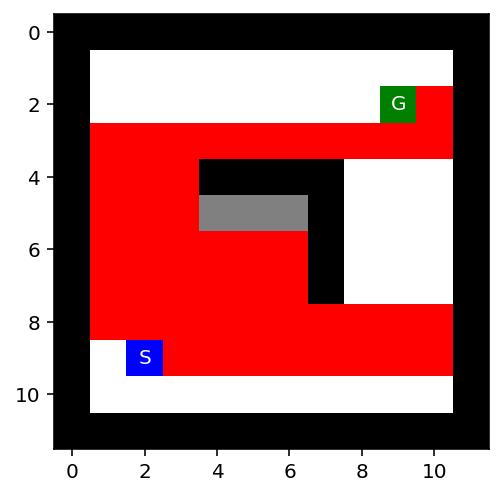

loops_maze.txt :
Solution Node:  Node - pos = (1, 1); parent = <__main__.Node object at 0x0000024AFCCE9220>; action = W; cost = 27


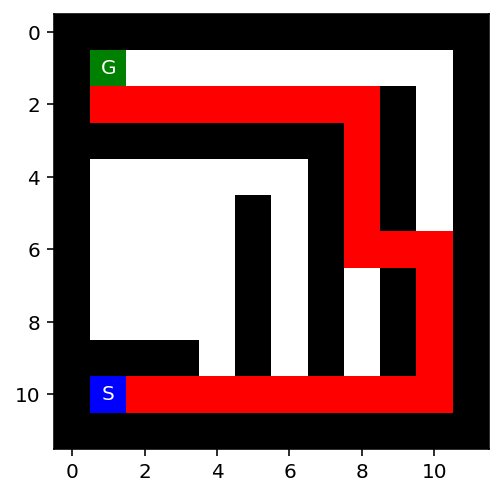

empty_maze.txt :
Solution Node:  Node - pos = (2, 9); parent = <__main__.Node object at 0x0000024AFCE83D30>; action = N; cost = 70


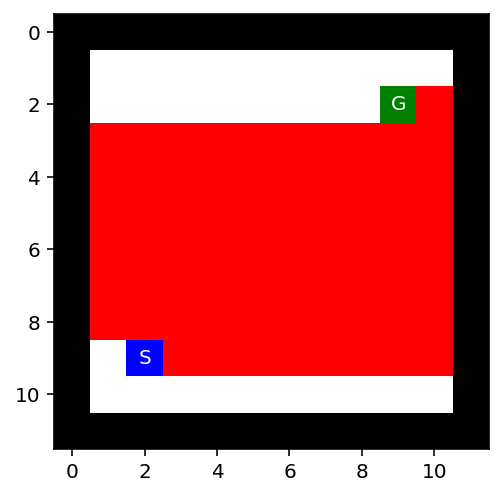

empty_2_maze.txt :
Solution Node:  Node - pos = (9, 2); parent = <__main__.Node object at 0x0000024AFE41BA90>; action = S; cost = 74


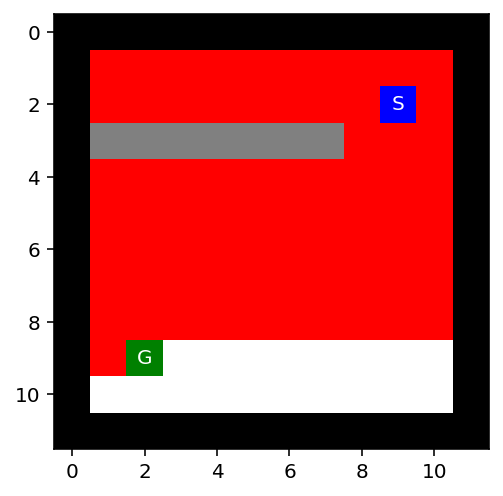

In [12]:
import pandas as pd
#use pandas to dispaly as table
col_names=['FileName', 'Path Cost', 'Max Frontier Size', 'Num Nodes Visited', 'Max Tree depth']
data_out = []
df = pd.DataFrame(data_out, columns=col_names)
fileNames = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
verbose = True

#do DFS
for i in fileNames:
    #parse maze:
    f = open(i, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    #perform DFS and get stats:
    start_pos = find_pos(maze, what="S")
    root = Node(pos=start_pos, parent=None, action=None, cost=0)  # make root node
    #---- BEGIN SEARCH -----
    goalNode_curr = myDFS(maze, root)
    #---- END SEARCH ----- result stored in goal node
    max_frontier_curr = max_frontier_size
    num_nodes_curr = num_nodes_expanded
    max_tree_depth_curr = max_tree_depth
    #get final path
    myList = []
    temp = goalNode_curr
    while temp != root:
        myList.append(temp.pos)
        temp = temp.parent
    #update maze for displaying
    for x in myList:
        maze[x[0]][x[1]] = "P"
    for x in visited:
        if(x not in myList):
            maze[x[0]][x[1]] = "."
    maze[goalNode_curr.pos[0]][goalNode_curr.pos[1]] = "G"
    maze[start_pos[0]][start_pos[1]] = "S"

    #ouptut solution data:
    fileName = i
    if verbose:
        print(fileName, ':')
        print('Solution Node: ', goalNode_curr)
        show_maze(maze)
    
    #append data to the pandas dataframe
    data = [fileName, goalNode_curr.cost, max_frontier_curr, num_nodes_curr, max_tree_depth_curr]
    df.loc[len(df.index)] = data

DFS_df = df

In [13]:
DFS_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,small_maze.txt,37,5,54,37
1,medium_maze.txt,130,8,147,130
2,large_maze.txt,210,37,424,222
3,open_maze.txt,330,326,902,330
4,wall_maze.txt,48,54,52,48
5,loops_maze.txt,27,12,28,27
6,empty_maze.txt,70,74,71,70
7,empty_2_maze.txt,74,73,82,74


<i>How do you deal with loops (cycles)?:</i>

Cycles are potentially extremely harmful when performing a BFS/DFS because these cycles can cause an infinite loop, never-ending cycle, or non-optimal paths. To detect a cycle with DFS, when looking/evaluating a new space, we make sure the space is not in the frontier. If a space is in the frontier then the space has been previously visited. Meaning, we do not visit duplicate spaces. Ideally, a recursive function calling DFS/BFS could be used to detect cycles, but we just decided to avoid cycles in our search by not visiting duplicate spaces. Not visiting duplciate spaces and getting rid of cycles is handled in the getChildNodes function. Likewise with BFS, we use a comparison statement to make sure we do not visit nodes twice (e.g in a loop). 

<i>Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?</i>

The implementations of BFS/DFS are complete in the sense that they always find a solution- if a valid solution exists. This completeness can be seen in the results dataframes because a solution can always be seen.

<i>Depth First Search</i> by nature is suboptimal because it returns the first solution it finds, not necessarily the best solution. Meaning, the search can return the solution with the best path cost, but it just returns the first solution found to reach the goal state. In terms of DFS, I made sure to make the space complexity optimal by releasing parent nodes of exhausted/incorrect pathways (deleting the whole tree and freeing up that allocated memory). The worst-case scenario time complexity of my DFS implementation expanding all paths, which more than likely will happen if enough mazes are used in testing, is O(b^m) [where m = max depth and b = branches]. Best case scenario space complexity of DFS is linear space, however my implementation stored the “reached data-structure.” The space complexity of my DFS is O(bmr) where [where m = max depth, b = branches, and r = spaces reached]. The reached data structure is stored in my implementation so linear space was not achieved.

<i>Breadth First Search</i> (BFS), is complete because the FIFO structure of a queue as the frontier expands every single path possible in order to find the optimal solution. In this case, the BFS is optimal because every node/state has the same path cost of 1 for each step/action. BFS operates by creating a search tree where b=branches, and where depth d=depth of optimal solution. For BFS, normally space complexity is a bigger problem than time (because each individual pathway needs to be stored in memory. For my implementation, space complexity is O(b^d*r) [where b= branches, d= max depth, as well as storing the reached nodes]. The space complexity is definitely very large because all these individually visited pathways must be stored. Time complexity for BFS is similar to the space complexity: O(b^d) [where b= branches, d= max depth]. 


<hr>

## Task 3: Implement greedy best-first search and A* search  [4 points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function.

# Greedy best-first search:

In [14]:
def HeuristicFunction(node, maze): #calculate Manhattan distance and return integer value representation
    #Manhattan distance = x_distance + y_distance
    goal_pos = find_pos(maze, what="G")
    x_val = abs (goal_pos[0] - node.pos[0])
    y_val = abs (goal_pos[1] - node.pos[1])
    return (x_val + y_val)

#--------------------
from collections import deque
max_frontier_size = 0
max_tree_depth = 0
num_nodes_expanded = 0
visited = []

class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}"

#helper function returning list of valid potential child nodes:
def getChildNodes(myNode, myMaze, frontier):
    childList = []
    #pass in a node, and return a list of a valid child arrays
    lookPos_1 = myNode.pos[0] + 1, myNode.pos[1]
    lookPos_2 = myNode.pos[0] - 1, myNode.pos[1]
    lookPos_3 = myNode.pos[0], myNode.pos[1] - 1
    lookPos_4 = myNode.pos[0], myNode.pos[1] + 1
    #look at all potential spaces
    if look(myMaze, lookPos_1) != 'X' and not lookPos_1 in frontier:
        newChild = Node(pos = lookPos_1, parent = myNode, action = "E", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_2) != 'X' and not lookPos_2 in frontier:
        newChild = Node(pos = lookPos_2, parent = myNode, action = "W", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_3) != 'X' and not lookPos_3 in frontier:
        newChild = Node(pos = lookPos_3, parent = myNode, action = "N", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_4) != 'X' and not lookPos_4 in frontier:
        newChild = Node(pos = lookPos_4, parent = myNode, action = "S", cost = myNode.cost + 1)
        childList.append(newChild)
    #return the actual child list
    return childList


#greedy Best First Search
#greedy Best First Search
def greedyBestSearch(maze, root):
    # variable intilization:
    global max_frontier_size
    global max_tree_depth
    global num_nodes_expanded
    max_frontier_size = 0
    max_tree_depth = 0
    num_nodes_expanded = 0
    q = []
    global visited
    visited = []
    q.append(root)  # stack intilization
    # actual DFS:
    while (len(q) > 0):  # while frontier/stack is not empty
        currNode = q.pop()
        visited.append(currNode.pos)

        # ------ BEGIN STAT KEEPING -----
        num_nodes_expanded = num_nodes_expanded + 1
        if num_nodes_expanded >= 20000:
            return root
        if currNode.cost > max_tree_depth:
            max_tree_depth = currNode.cost
        if len(q) > max_frontier_size:
            max_frontier_size = len(q)
        # ------- END STAT KEEPING -------

        if look(maze, currNode.pos) == 'G':  # GOAL STATE FOUND
            #print('found')
            return currNode
        # looking at potential children children nodes
        childList = getChildNodes(currNode, maze, visited)
        # GET HEURISTIC VAL:
        myList = []  # dictionary with structure {heuristic value, node}
        for eachNode in childList:
            Greedy_Value = HeuristicFunction(eachNode, maze)
            my_pair = eachNode, Greedy_Value
            myList.append(my_pair)
        # sort in ascending order to put them in "greedy" order
        myList.sort(key=lambda x: x[1])
        for x in myList:
            if not (x[0] in q):
                q.append(x[0])

    print('failure')
    return root

small_maze.txt :
Solution Node:  Node - pos = (8, 1); parent = <__main__.Node object at 0x0000024AFCE633A0>; action = N; cost = 37


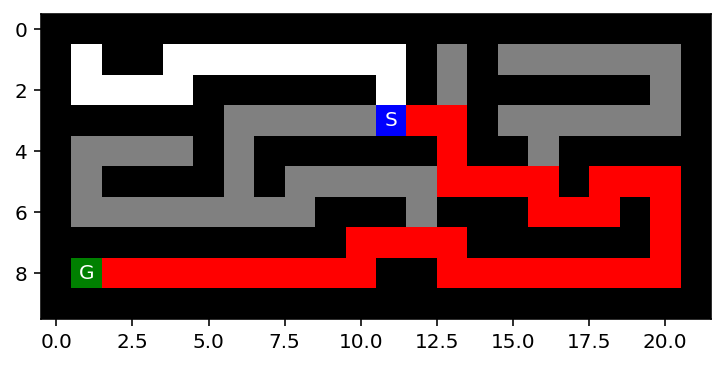

medium_maze.txt :
Solution Node:  Node - pos = (16, 1); parent = <__main__.Node object at 0x0000024AFCDC2B50>; action = N; cost = 130


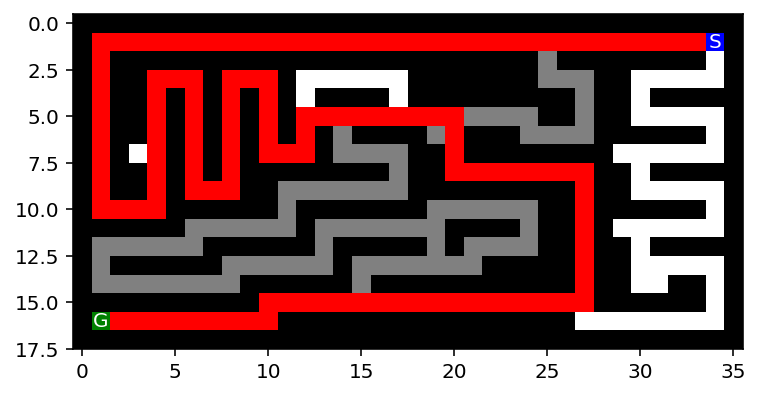

large_maze.txt :
Solution Node:  Node - pos = (35, 1); parent = <__main__.Node object at 0x0000024AFCD92850>; action = E; cost = 210


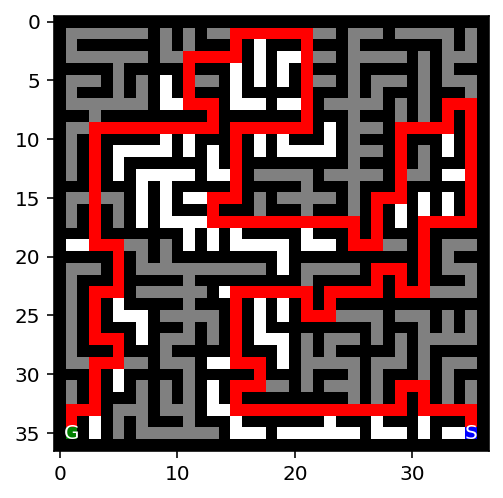

open_maze.txt :
Solution Node:  Node - pos = (21, 1); parent = <__main__.Node object at 0x0000024AFCE9A820>; action = N; cost = 382


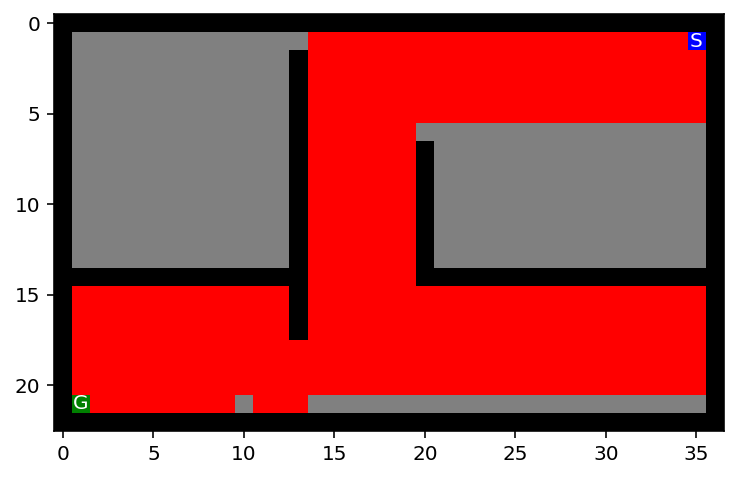

wall_maze.txt :
Solution Node:  Node - pos = (2, 9); parent = <__main__.Node object at 0x0000024AFCB51160>; action = N; cost = 68


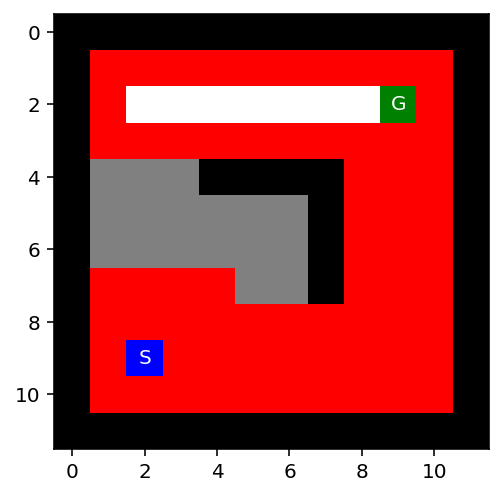

loops_maze.txt :
Solution Node:  Node - pos = (1, 1); parent = <__main__.Node object at 0x0000024AFCE34760>; action = W; cost = 27


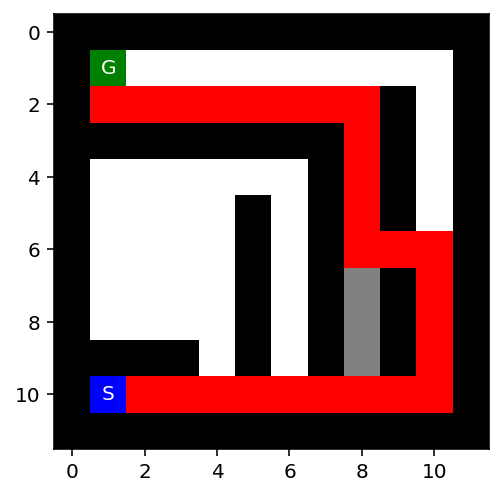

empty_maze.txt :
Solution Node:  Node - pos = (2, 9); parent = <__main__.Node object at 0x0000024AFE44AEE0>; action = W; cost = 80


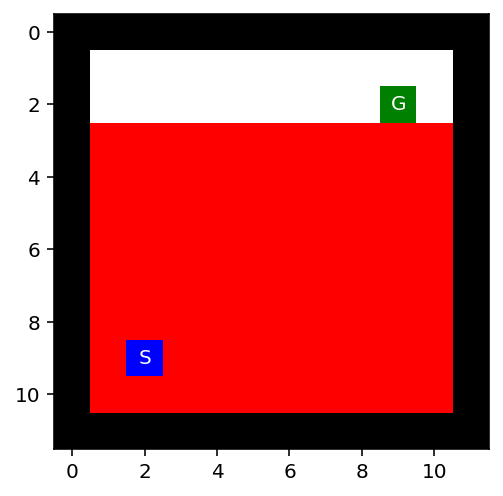

empty_2_maze.txt :
Solution Node:  Node - pos = (9, 2); parent = <__main__.Node object at 0x0000024AFCC0FEE0>; action = E; cost = 80


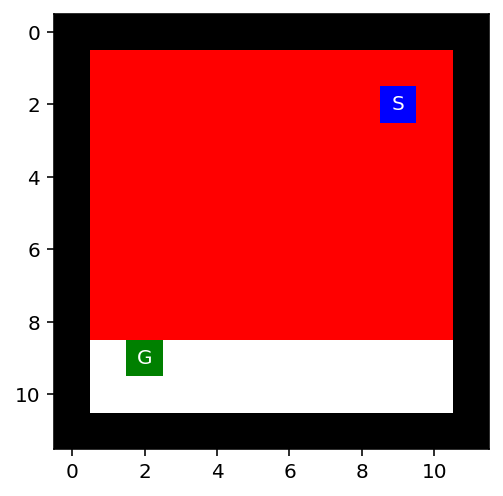

In [15]:
import pandas as pd
#use pandas to dispaly as table
col_names=['FileName', 'Path Cost', 'Max Frontier Size', 'Num Nodes Visited', 'Max Tree depth']
data_out = []
df = pd.DataFrame(data_out, columns=col_names)
fileNames = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
verbose = True

#do GBS
for i in fileNames:
    #parse maze:
    f = open(i, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    #perform DFS and get stats:
    start_pos = find_pos(maze, what="S")
    root = Node(pos=start_pos, parent=None, action=None, cost=0)  # make root node
    #---- BEGIN SEARCH -----
    goalNode_curr = greedyBestSearch(maze, root)
    #---- END SEARCH ----- result stored in goal node
    max_frontier_curr = max_frontier_size
    num_nodes_curr = num_nodes_expanded
    max_tree_depth_curr = max_tree_depth
    #get final path
    myList = []
    temp = goalNode_curr
    while temp != root:
        myList.append(temp.pos)
        temp = temp.parent
    #update maze for displaying
    for x in myList:
        maze[x[0]][x[1]] = "P"
    for x in visited:
        if(x not in myList):
            maze[x[0]][x[1]] = "."
    maze[goalNode_curr.pos[0]][goalNode_curr.pos[1]] = "G"
    maze[start_pos[0]][start_pos[1]] = "S"

    #ouptut solution data:
    fileName = i
    if verbose:
        print(fileName, ':')
        print('Solution Node: ', goalNode_curr)
        show_maze(maze)
    
    #append data to the pandas dataframe
    data = [fileName, goalNode_curr.cost, max_frontier_curr, num_nodes_curr, max_tree_depth_curr]
    df.loc[len(df.index)] = data

greedy_df = df

In [16]:
greedy_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,small_maze.txt,37,5,80,44
1,medium_maze.txt,130,11,216,183
2,large_maze.txt,210,35,510,222
3,open_maze.txt,382,349,914,382
4,wall_maze.txt,68,58,94,72
5,loops_maze.txt,27,11,31,27
6,empty_maze.txt,80,72,81,80
7,empty_2_maze.txt,80,72,81,80


# A* search:

In [17]:
def AStarHeuristicFunction(node, maze): #calculate A* heuristic
    #AStarHeuristic: f(n) = g(n) + h(n)
    # where
    # g(n) = path cost to current node (get cost from root)
    # h(n) = Manhattan distance = x_distance + y_distance
    #get h(n):
    goal_pos = find_pos(maze, what="G")
    x_val = abs (goal_pos[0] - node.pos[0])
    y_val = abs (goal_pos[1] - node.pos[1])
    h = x_val + y_val #h(n)
    #get g(n):
    g = node.cost
    temp = node
    while temp != root:
        temp = temp.parent
        g = g + temp.cost 

    #get h(n)
    h = g + h
    return h

#--------------------
from collections import deque
max_frontier_size = 0
max_tree_depth = 0
num_nodes_expanded = 0
visited = []

class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}"

#helper function returning list of valid potential child nodes:
def getChildNodes(myNode, myMaze, frontier):
    childList = []
    #pass in a node, and return a list of a valid child arrays
    lookPos_1 = myNode.pos[0] + 1, myNode.pos[1]
    lookPos_2 = myNode.pos[0] - 1, myNode.pos[1]
    lookPos_3 = myNode.pos[0], myNode.pos[1] - 1
    lookPos_4 = myNode.pos[0], myNode.pos[1] + 1
    #look at all potential spaces
    if look(myMaze, lookPos_1) != 'X' and not lookPos_1 in frontier:
        newChild = Node(pos = lookPos_1, parent = myNode, action = "E", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_2) != 'X' and not lookPos_2 in frontier:
        newChild = Node(pos = lookPos_2, parent = myNode, action = "W", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_3) != 'X' and not lookPos_3 in frontier:
        newChild = Node(pos = lookPos_3, parent = myNode, action = "N", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_4) != 'X' and not lookPos_4 in frontier:
        newChild = Node(pos = lookPos_4, parent = myNode, action = "S", cost = myNode.cost + 1)
        childList.append(newChild)
    #return the actual child list
    return childList


#a* search
def astarSearch(maze, root):
    # ---start stat keeping
    global max_frontier_size
    global max_tree_depth
    global num_nodes_expanded
    max_frontier_size = 0
    max_tree_depth = 0
    num_nodes_expanded = 0
    # ---end stat keeping
    q = deque()  # frontier as a queue
    reached = []
    q.append(root)  # queue intilization
    # actual BFS:
    while (len(q) > 0):  # while frontier/stack is not empty
        currNode = q.popleft()  # node -> pop(frontier)
        reached.append(currNode.pos)  # updated reached
        childList = getChildNodes(currNode, maze, reached)  #

        # ------ BEGIN STAT KEEPING -----
        num_nodes_expanded = num_nodes_expanded + 1
        if currNode.cost > max_tree_depth:
            max_tree_depth = currNode.cost
        if len(q) > max_frontier_size:
            max_frontier_size = len(q)
        # ------- END STAT KEEPING -------
        myList = []  # dictionary with structure {heuristic value, node}
        for eachNode in childList:
            huer_val = AStarHeuristicFunction(eachNode, maze)
            my_pair = eachNode, huer_val
            myList.append(my_pair)
        # sort in ascending order to enque them in "greedy" order
        for i in myList:
            currChild = i[0]
            if look(maze, currChild.pos) == 'G':
                # print('found')
                return currChild
            # print(i)
            if not (currChild.pos in reached):
                q.append(currChild)
                reached.append(currChild.pos)
    print('failure')
    return root


small_maze.txt :
Solution Node:  Node - pos = (8, 1); parent = <__main__.Node object at 0x0000024AFCCDBDF0>; action = N; cost = 19


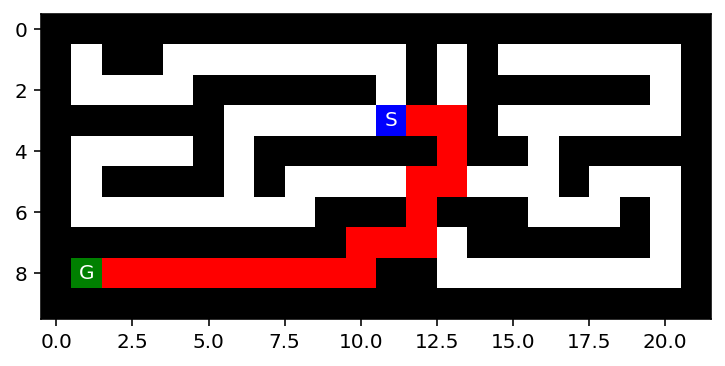

medium_maze.txt :
Solution Node:  Node - pos = (16, 1); parent = <__main__.Node object at 0x0000024AFCC21FA0>; action = N; cost = 68


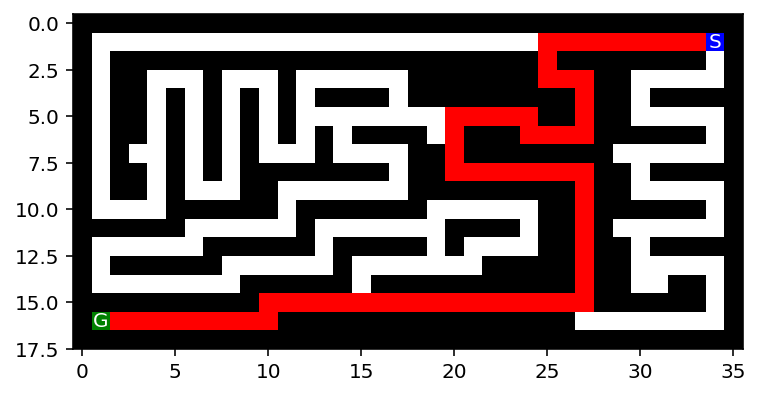

large_maze.txt :
Solution Node:  Node - pos = (35, 1); parent = <__main__.Node object at 0x0000024AFD080730>; action = E; cost = 210


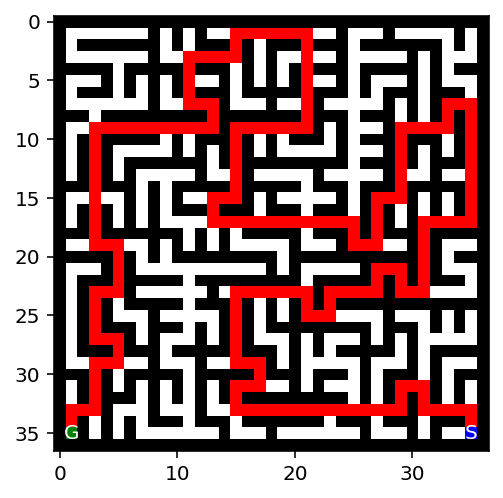

open_maze.txt :
Solution Node:  Node - pos = (21, 1); parent = <__main__.Node object at 0x0000024AFCC1D070>; action = N; cost = 54


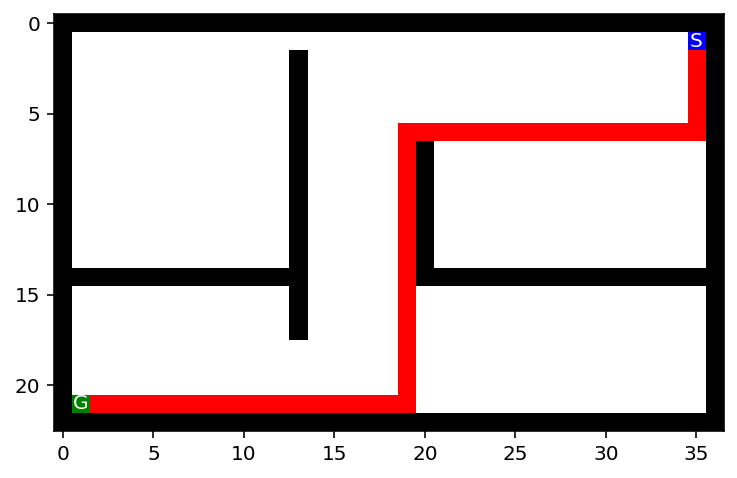

wall_maze.txt :
Solution Node:  Node - pos = (2, 9); parent = <__main__.Node object at 0x0000024AFCD55D30>; action = S; cost = 14


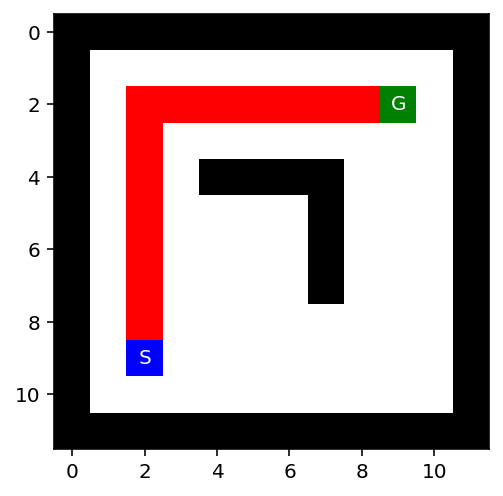

loops_maze.txt :
Solution Node:  Node - pos = (1, 1); parent = <__main__.Node object at 0x0000024AFCE5E850>; action = N; cost = 23


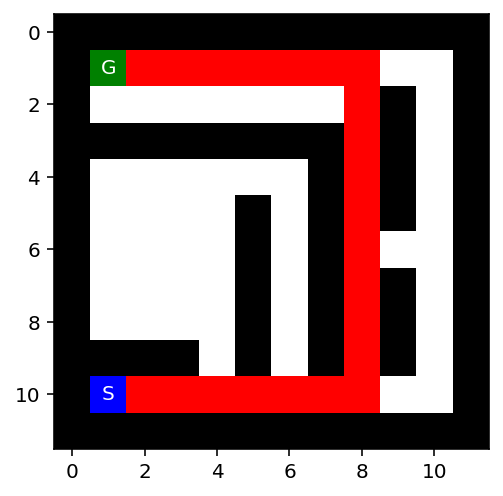

empty_maze.txt :
Solution Node:  Node - pos = (2, 9); parent = <__main__.Node object at 0x0000024AFCD5B430>; action = S; cost = 14


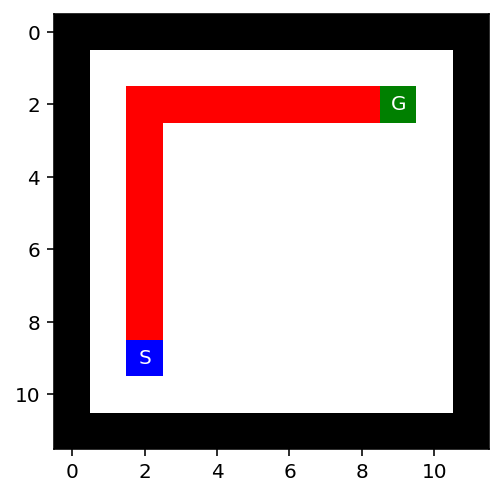

empty_2_maze.txt :
Solution Node:  Node - pos = (9, 2); parent = <__main__.Node object at 0x0000024AE8BC53A0>; action = N; cost = 14


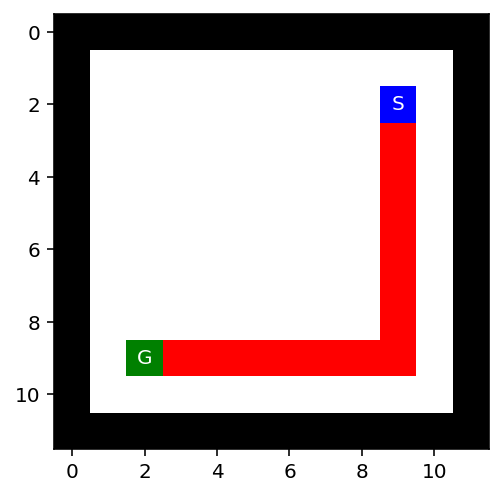

In [18]:
import pandas as pd
#use pandas to dispaly as table
col_names=['FileName', 'Path Cost', 'Max Frontier Size', 'Num Nodes Visited', 'Max Tree depth']
data_out = []
df = pd.DataFrame(data_out, columns=col_names)
fileNames = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", "open_maze.txt", "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
verbose = True

#do a*
for i in fileNames:
    #parse maze:
    f = open(i, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    #perform DFS and get stats:
    start_pos = find_pos(maze, what="S")
    root = Node(pos=start_pos, parent=None, action=None, cost=0)  # make root node
    #---- BEGIN SEARCH -----
    goalNode_curr = astarSearch(maze, root)
    #---- END SEARCH ----- result stored in goal node
    max_frontier_curr = max_frontier_size
    num_nodes_curr = num_nodes_expanded
    max_tree_depth_curr = max_tree_depth
    #get final path
    myList = []
    temp = goalNode_curr
    while temp != root:
        myList.append(temp.pos)
        temp = temp.parent
    #update maze for displaying
    for x in myList:
        maze[x[0]][x[1]] = "P"
    for x in visited:
        if(x not in myList):
            maze[x[0]][x[1]] = "."
    maze[goalNode_curr.pos[0]][goalNode_curr.pos[1]] = "G"
    maze[start_pos[0]][start_pos[1]] = "S"

    #ouptut solution data:
    fileName = i
    if verbose:
        print(fileName, ':')
        print('Solution Node: ', goalNode_curr)
        show_maze(maze)
    
    #append data to the pandas dataframe
    data = [fileName, goalNode_curr.cost, max_frontier_curr, num_nodes_curr, max_tree_depth_curr]
    df.loc[len(df.index)] = data

astar_df = df

In [19]:
astar_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,small_maze.txt,19,7,90,18
1,medium_maze.txt,68,7,267,67
2,large_maze.txt,210,7,616,209
3,open_maze.txt,54,24,679,53
4,wall_maze.txt,14,10,85,13
5,loops_maze.txt,23,7,70,22
6,empty_maze.txt,14,11,92,13
7,empty_2_maze.txt,14,11,92,13


<i> Are your implementations complete and optimal? What is the time and space complexity? </i>

<i>Greedy Best First Search</i> is always complete in a finite space (the maze is a finite environment). Meaning, if a solution exists, the informed search algorithm is guaranteed to find a solution. In the trails, a solution was found in every maze, supporting this point. By nature, Greedy Best First Search is not optimal, just searches for a solution quickly by expanding the “first the node with the lowest value h(n),” where h(n) is the heuristic function (Russel 84). Comparing to the optimal BFS, the GBS path cost is higher but the Number of Nodes visited is lower. Meaning, the GBS quickly searches for the goal state. The worst case time complexity is the same as BFS: O(b^m), where m = max tree depth and b = branches. The best case time complexity is O(bm) if the heuristic is 100% accurate (this was not the case for our testing environment). Meaning the time complexity for my implementation is  O(b^m) because the heuristic is not 100% accurate. For GBS, the space complexity is the same as the time complexity (typically O(b^m) because the heuristic is not 100% accurate). However, the reached data structure was populated for stat keeping ( therefore O(b^m * r) might be a more accurate space complexity). 

<i>A* Search</i> is complete because this informed search algorithm is guaranteed to expand the least number of nodes and always find a solution (which is why it is so common/popular). As seen in theory and by the results, by nature A* search algorithm is always optimal because it returns the path with the shortest path cost. The search algorithm does this because A* calculates the estimated cost, f(n), of any path going through any frontier node. Meaning, A* is optimal. Looking at BFS, A* has the same path cost, meaning they both perform optimally, in this maze enviornment (reminder: BFS is optimal when every action has the same path cost). The time complexity of A* is the number of nodes expanded, meaning A* has exponential time complexity. The time complexity for number of nodes expanded can be written as  f(n) ≤ C or exponentially as O(2^n). Likewise for A*, the space complexity is the same as the time complexity. 

<hr>

## Task 4: Comparison and discussion [2 points] 

Run experiments to compare the implemented algorithms and present the results as tables and charts.

<i>Discussion of my implementations:</i>

All of my search algorithm implementations utilize a "getChildNodes" helper function. The helper function utilizes the built-in look function to find valid nodes to travel to. For statkeeping, all the functions utilize the same global variables to increment stats such as path cost, tree depth, and frontier size. Just like the book/slides pseudocode, the Breadth first search utilized a FIFO queue for the frontier. In contrast, the Depth first search utilized a LIFO stack for the frontier. Both the A* and GBS search algorithms utilized these same implementations and helper functions, however, they utilized heuristics to help decide which node to travel to next. The GBS heuristic was the Manhattan distance (x distance minus y distance), rather than the euclidean distance. The A* heuristic was path cost to current node added to the Manhattan distance.

For testing, we utilized a for loop, iterating through each file name for each search algorithm type. The data was then stored into a numpy array and appended to a pandas dataframe. The dataframe could then be displayed in a logical format.
<hr> <br>


Note: The filenames/datapoints in order are small_maze.txt, medium_maze.txt, large_maze.txt, open_maze.txt, wall_maze.txt, loops_maze.txt, empty_maze.txt, empty_2_maze.txt. 

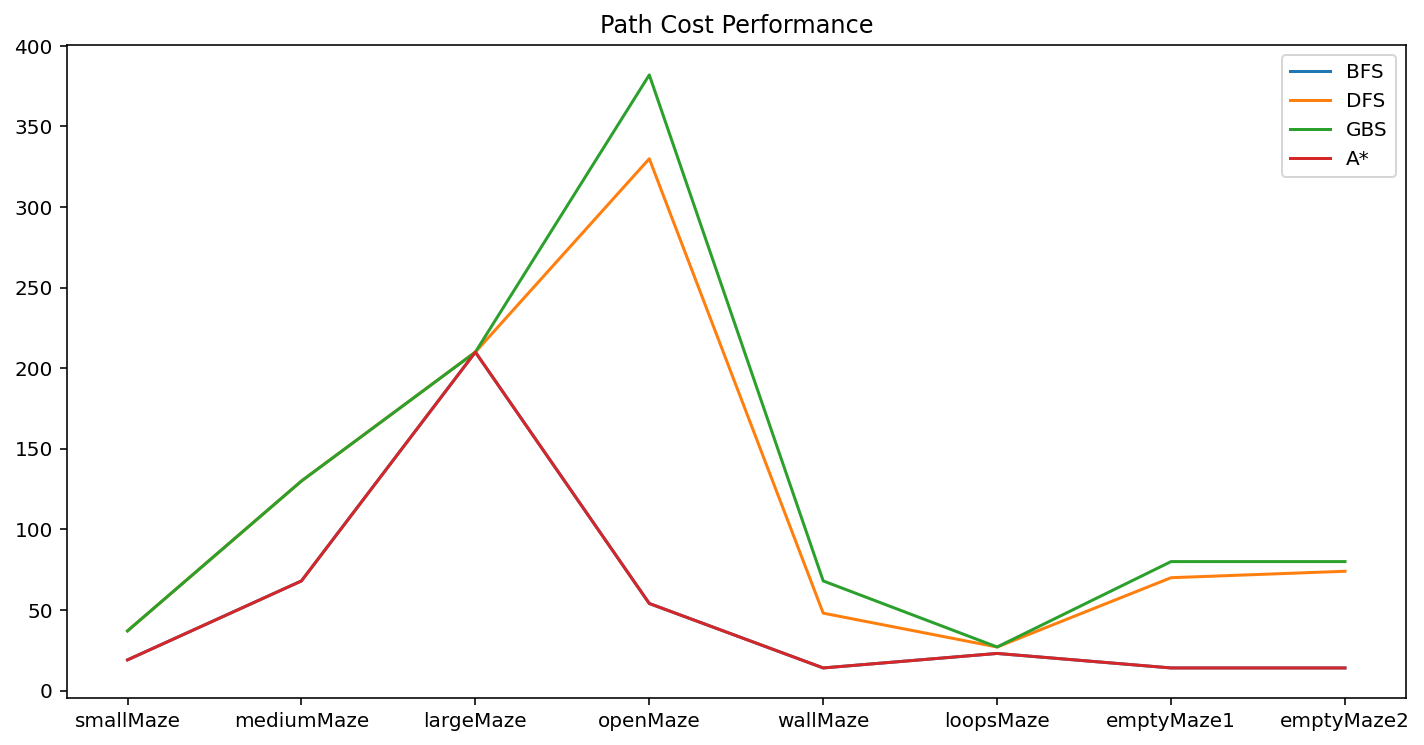

In [20]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fileNames = ["smallMaze", "mediumMaze", "largeMaze", "openMaze", "wallMaze", "loopsMaze", "emptyMaze1", "emptyMaze2"]

# Resutls of Expirements ran above
fig = plt.figure(figsize=(12, 6))
plt.plot(fileNames, BFS_df["Path Cost"].to_numpy(), label='BFS')
plt.plot(fileNames, DFS_df["Path Cost"].to_numpy(), label='DFS')
plt.plot(fileNames, greedy_df["Path Cost"].to_numpy(), label='GBS')
plt.plot(fileNames, astar_df["Path Cost"].to_numpy(), label='A*')
plt.legend()
plt.title('Path Cost Performance')
plt.show()

The above plot is the Path Cost Performance for each search algorithm. The reason the BFS line can't be seen is because it's performance is identical to A* (A* covers it up). As expected, the A* and BFS search algorthims had optimal and the best performance. GBS and DFS had similar performances and worse than A*/BFS (as expected). The large maze had the same path cost for all solutions, meaning most likely there is only one valid solution. Looking at the figure, the "empty maze" having a large path cost and seeing a large spike makes sense. In the empty maze the DFS is almost randomly searching for the goal state, so it makes sense that the path cost is extremely high.

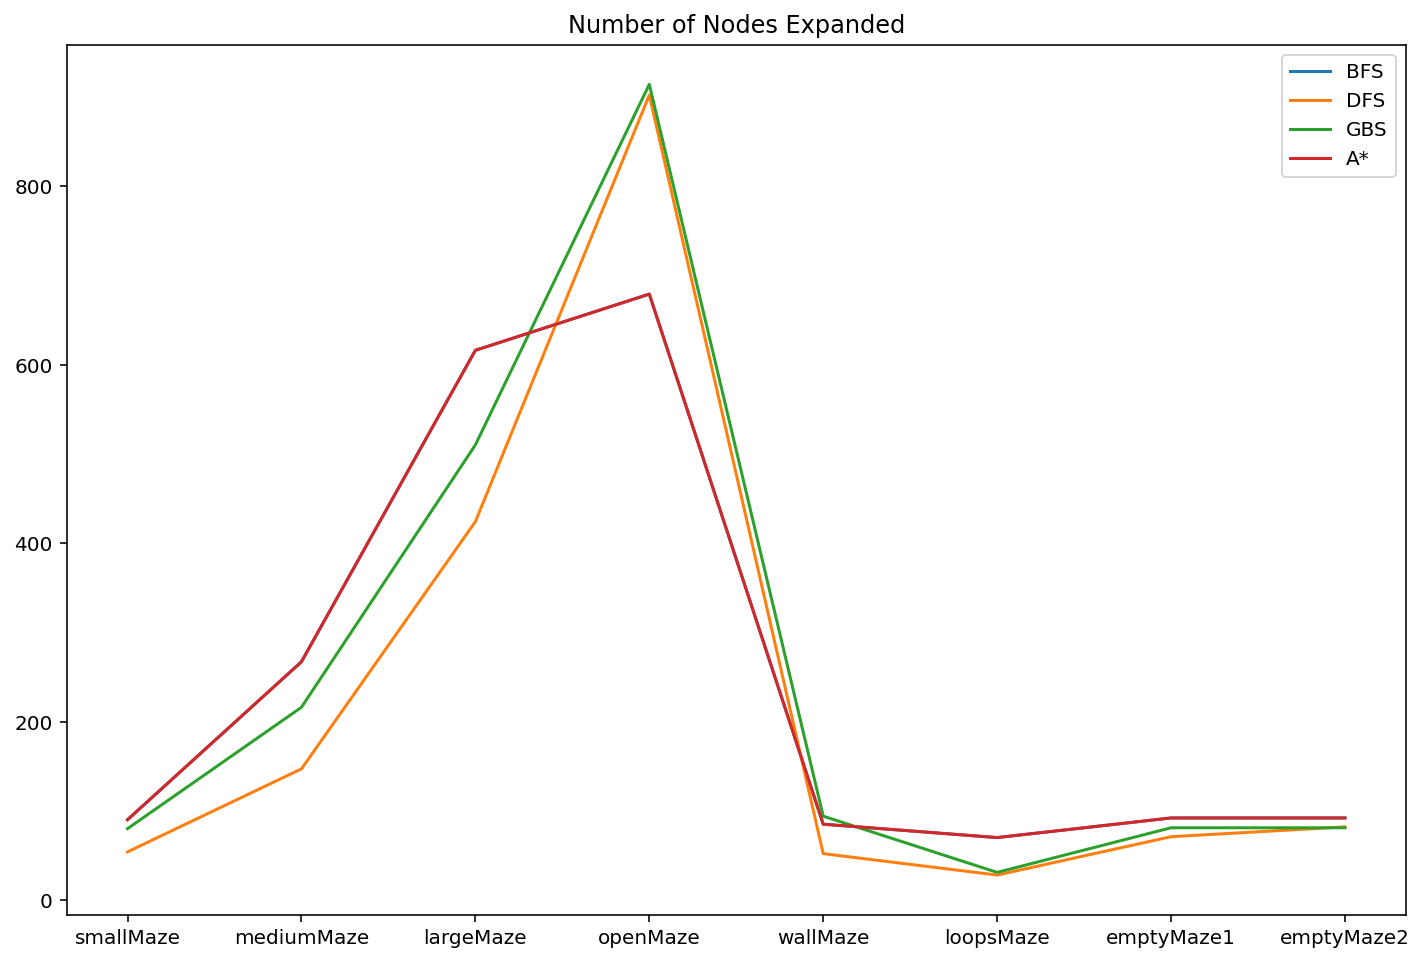

In [21]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fileNames = ["smallMaze", "mediumMaze", "largeMaze", "openMaze", "wallMaze", "loopsMaze", "emptyMaze1", "emptyMaze2"]

fig = plt.figure(figsize=(12, 8))
plt.plot(fileNames, BFS_df["Num Nodes Visited"].to_numpy(), label='BFS')
plt.plot(fileNames, DFS_df["Num Nodes Visited"].to_numpy(), label='DFS')
plt.plot(fileNames, greedy_df["Num Nodes Visited"].to_numpy(), label='GBS')
plt.plot(fileNames, astar_df["Num Nodes Visited"].to_numpy(), label='A*')
plt.legend()
plt.title('Number of Nodes Expanded')
plt.show()

In the majority of cases, DFS & GBS expands less nodes than both the optimal search algorithms (this behavior is expected because DFS focus on returning the solution quickly). Also it makes sense that there is a very large spike in nodes expanded when using DFS/GBS on the empty maze because it almost randomly searches for a solution (taking a very long time). In summary, the BFS and A* search are optimal expanding more nodes on average than the DFS/GBS, which just randomly searhces for an exit point (DFS) or uses a heuristic to find the exit quickly (GBS). 

<i>Complete the following table for each maze.</i>

In [22]:
#output Breadth first search dataframe:
BFS_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,small_maze.txt,19,7,90,18
1,medium_maze.txt,68,7,267,67
2,large_maze.txt,210,7,616,209
3,open_maze.txt,54,24,679,53
4,wall_maze.txt,14,10,85,13
5,loops_maze.txt,23,7,70,22
6,empty_maze.txt,14,11,92,13
7,empty_2_maze.txt,14,11,92,13


In [23]:
#output depth first search dataframe:
DFS_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,small_maze.txt,37,5,54,37
1,medium_maze.txt,130,8,147,130
2,large_maze.txt,210,37,424,222
3,open_maze.txt,330,326,902,330
4,wall_maze.txt,48,54,52,48
5,loops_maze.txt,27,12,28,27
6,empty_maze.txt,70,74,71,70
7,empty_2_maze.txt,74,73,82,74


In [24]:
#output greedy best first search results dataframe
greedy_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,small_maze.txt,37,5,80,44
1,medium_maze.txt,130,11,216,183
2,large_maze.txt,210,35,510,222
3,open_maze.txt,382,349,914,382
4,wall_maze.txt,68,58,94,72
5,loops_maze.txt,27,11,31,27
6,empty_maze.txt,80,72,81,80
7,empty_2_maze.txt,80,72,81,80


In [25]:
#output a* search results dataframe
astar_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,small_maze.txt,19,7,90,18
1,medium_maze.txt,68,7,267,67
2,large_maze.txt,210,7,616,209
3,open_maze.txt,54,24,679,53
4,wall_maze.txt,14,10,85,13
5,loops_maze.txt,23,7,70,22
6,empty_maze.txt,14,11,92,13
7,empty_2_maze.txt,14,11,92,13


Proffessor approved the above table formats

<i> Discuss the most important lessons you have learned from implementing the different search strategies. </i>

One important lesson learned is that different search algorithms are used to accomplish different goals. For example, if a solution is needed quickly a Greedy Best First Search might be better to use than something like BFS search. Likewise when choosing to utilize a BFS or DFS search, one must know the time complexities versus space complexities vary greatly. Working with BFS might not be the best case if space is limited because the space complexity can become vary large, with storing all these reached paths and keeping track of the reached states. On the other hand, if limited space is an issue DFS can achieve linear space. On the other hand, the execution time could be very long if the tree depth is very large. Like DFS, not every search algorithm hopes to achieve the optimal solution. Some searches reach the solution more quickly by giving a best effort approach (Greedy Best First Search) or just return the first found solution (Depth First Search). Searches like BFS or A* focus on optimality. 

Another learned lesson is the importance of an accurate heuristic. Using the “Manhattan distance” heuristic for normal/regular mazes (small, medium, large) on yields more accurate/better results. However, for abnormal/irregular mazes (loops.txt, walls.txt, etc.) this heuristic yields worse results. The Manhattan distance works well for normal designed mazes, however with these irregular movement patterns moving to random children is more efficient. The calculation for what would normally be the correct direction does not apply in these special case (this is why GBS and A* performed worse than DFS/BFS for these special mazes (the heuristic wasn’t accurate enough)). Overall, an accurate heuristic based on each environment needs to be utilized to get efficient/optimal results when using informed search algorithms (such as A* and GBS)


<hr>

## Graduate student advanced task: Multiple Goals [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

Create a few mazes with multiple goals by adding a one or two more goals to the medium sizes maze.
Solve the maze with your implementations for DFS, BFS, and implement IDS (iterative deepening search using DFS). Run experiments to show which implementations find the optimal solution.

medium_maze_two.txt :


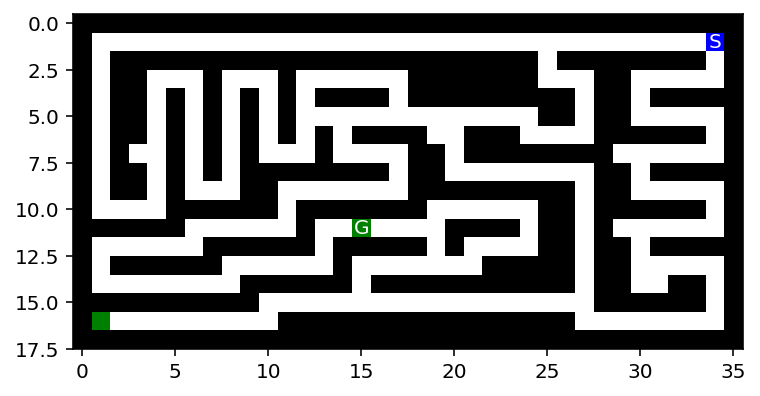

medium_maze_three.txt :


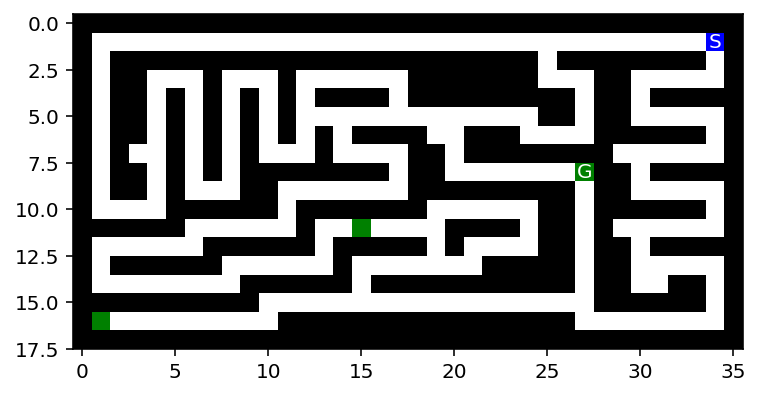

medium_maze_short.txt :


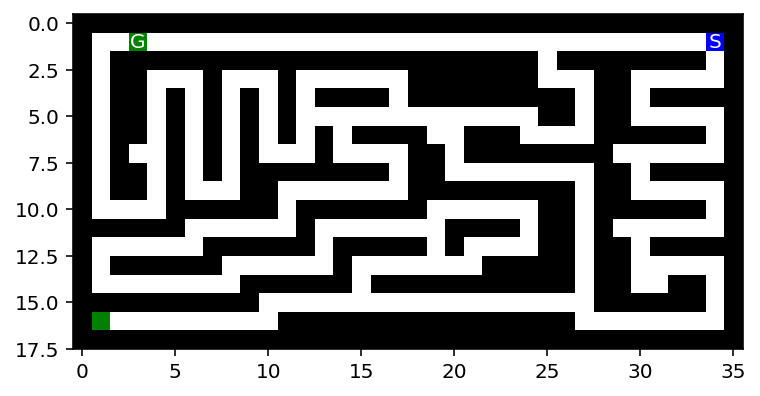

In [26]:
#DISPLAYING MY NEW MAZES:
#created three new mazes: medium_maze_two (2 goals)  and medium_maze_three (3 goals), medium_maze_short (2 goals)
fileNames = ["medium_maze_two.txt", "medium_maze_three.txt", "medium_maze_short.txt"]

#display mazes
for i in fileNames:
    f = open(i, "r")
    print(i, ':')
    maze_str = f.read()
    maze = parse_maze(maze_str) #parse maze
    show_maze(maze)


Breadth First Search on these new mazes:

In [27]:
#RUNNING MY IMPLEMENTATION OF BFS ON THE MAZES 
import pandas as pd
#use pandas to dispaly as table
col_names=['FileName', 'Path Cost', 'Max Frontier Size', 'Num Nodes Visited', 'Max Tree depth']
data_out = []
df = pd.DataFrame(data_out, columns=col_names)
fileNames = ["medium_maze_two.txt", "medium_maze_three.txt", "medium_maze_short.txt"]
verbose = True

#do DFS
for i in fileNames:
    #parse maze:
    f = open(i, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    #perform DFS and get stats:
    start_pos = find_pos(maze, what="S")
    root = Node(pos=start_pos, parent=None, action=None, cost=0)  # make root node
    goalNode_curr = myBFS(maze, root)
    max_frontier_curr = max_frontier_size
    num_nodes_curr = num_nodes_expanded
    max_tree_depth_curr = max_tree_depth
    #get final path
    myList = []
    temp = goalNode_curr
    while temp != root:
        myList.append(temp.pos)
        temp = temp.parent
    #ouptut solution data:
    fileName = i
    if verbose:
        print(fileName, ':')
        print('Solution Node: ', goalNode_curr)
        print('Squares on final path:', myList)
        print('All squares visited marked as visited in the visited List. Not printed due to size')
        #print('visited Nodes: ', visited, '\n')
        print('--------------------------------------------------------------------------')
    #append to the pandas dataframe
    data = [fileName, goalNode_curr.cost, max_frontier_curr, num_nodes_curr, max_tree_depth_curr]
    df.loc[len(df.index)] = data

new_BFS_df = df

medium_maze_two.txt :
Solution Node:  Node - pos = (11, 15); parent = <__main__.Node object at 0x0000024AFE44FB80>; action = N; cost = 65
Squares on final path: [(11, 15), (11, 16), (11, 17), (11, 18), (11, 19), (12, 19), (13, 19), (13, 18), (13, 17), (13, 16), (13, 15), (14, 15), (15, 15), (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (15, 21), (15, 22), (15, 23), (15, 24), (15, 25), (15, 26), (15, 27), (14, 27), (13, 27), (12, 27), (11, 27), (10, 27), (9, 27), (8, 27), (8, 26), (8, 25), (8, 24), (8, 23), (8, 22), (8, 21), (8, 20), (7, 20), (6, 20), (5, 20), (5, 21), (5, 22), (5, 23), (5, 24), (6, 24), (6, 25), (6, 26), (6, 27), (5, 27), (4, 27), (3, 27), (3, 26), (3, 25), (2, 25), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33)]
All squares visited marked as visited in the visited List. Not printed due to size
--------------------------------------------------------------------------
medium_maze_three.txt :
Solution Node:  Node - pos = (8, 27); par

In [28]:
new_BFS_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,medium_maze_two.txt,65,7,251,64
1,medium_maze_three.txt,34,7,109,33
2,medium_maze_short.txt,31,6,93,30


Running DFS on these new mases:

In [29]:
#RUNNING MY IMPLEMENTATION OF BFS ON THE MAZES 
import pandas as pd
#use pandas to dispaly as table
col_names=['FileName', 'Path Cost', 'Max Frontier Size', 'Num Nodes Visited', 'Max Tree depth']
data_out = []
df = pd.DataFrame(data_out, columns=col_names)
fileNames = ["medium_maze_two.txt", "medium_maze_three.txt", "medium_maze_short.txt"]
verbose = True

#do DFS
for i in fileNames:
    #parse maze:
    f = open(i, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    #perform DFS and get stats:
    start_pos = find_pos(maze, what="S")
    root = Node(pos=start_pos, parent=None, action=None, cost=0)  # make root node
    goalNode_curr = myDFS(maze, root)
    max_frontier_curr = max_frontier_size
    num_nodes_curr = num_nodes_expanded
    max_tree_depth_curr = max_tree_depth
    #get final path
    myList = []
    temp = goalNode_curr
    while temp != root:
        myList.append(temp.pos)
        temp = temp.parent
    #ouptut solution data:
    fileName = i
    if verbose:
        print(fileName, ':')
        print('Solution Node: ', goalNode_curr)
        print('Squares on final path:', myList)
        print('All squares visited marked as visited in the visited List. Not printed due to size')
        #print('visited Nodes: ', visited, '\n')
        print('--------------------------------------------------------------------------')
    #append to the pandas dataframe
    data = [fileName, goalNode_curr.cost, max_frontier_curr, num_nodes_curr, max_tree_depth_curr]
    df.loc[len(df.index)] = data

new_DFS_df = df

medium_maze_two.txt :
Solution Node:  Node - pos = (16, 1); parent = <__main__.Node object at 0x0000024AFE426B80>; action = N; cost = 130
Squares on final path: [(16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15), (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (15, 21), (15, 22), (15, 23), (15, 24), (15, 25), (15, 26), (15, 27), (14, 27), (13, 27), (12, 27), (11, 27), (10, 27), (9, 27), (8, 27), (8, 26), (8, 25), (8, 24), (8, 23), (8, 22), (8, 21), (8, 20), (7, 20), (6, 20), (5, 20), (5, 19), (5, 18), (5, 17), (5, 16), (5, 15), (5, 14), (5, 13), (5, 12), (6, 12), (7, 12), (7, 11), (7, 10), (6, 10), (5, 10), (4, 10), (3, 10), (3, 9), (3, 8), (4, 8), (5, 8), (6, 8), (7, 8), (8, 8), (9, 8), (9, 7), (9, 6), (8, 6), (7, 6), (6, 6), (5, 6), (4, 6), (3, 6), (3, 5), (3, 4), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 4), (10, 4), (10, 3), (10, 2), (10, 1), (9, 1), (8, 1), (7, 1), (6, 1), (5, 1

In [30]:
new_DFS_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,medium_maze_two.txt,130,8,147,130
1,medium_maze_three.txt,96,7,113,100
2,medium_maze_short.txt,31,2,32,31


Implementing iterative deepening search:

For my implementation I am wrapping my DFS in a for loops, helps to streamline implementation and with global stat keeping variables.

In [31]:
import random

max_frontier_size = 0
max_tree_depth = 0
num_nodes_expanded = 0
visited = []

class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; parent = {repr(self.parent)}; action = {self.action}; cost = {self.cost}"

#helper function returning list of valid potential child nodes:
def getChildNodes(myNode, myMaze, frontier):
    childList = []
    #pass in a node, and return a list of a valid child arrays
    lookPos_1 = myNode.pos[0] + 1, myNode.pos[1]
    lookPos_2 = myNode.pos[0] - 1, myNode.pos[1]
    lookPos_3 = myNode.pos[0], myNode.pos[1] - 1
    lookPos_4 = myNode.pos[0], myNode.pos[1] + 1
    #look at all potential spaces
    if look(myMaze, lookPos_1) != 'X' and not lookPos_1 in frontier:
        newChild = Node(pos = lookPos_1, parent = myNode, action = "E", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_2) != 'X' and not lookPos_2 in frontier:
        newChild = Node(pos = lookPos_2, parent = myNode, action = "W", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_3) != 'X' and not lookPos_3 in frontier:
        newChild = Node(pos = lookPos_3, parent = myNode, action = "N", cost = myNode.cost + 1)
        childList.append(newChild)
    if look(myMaze, lookPos_4) != 'X' and not lookPos_4 in frontier:
        newChild = Node(pos = lookPos_4, parent = myNode, action = "S", cost = myNode.cost + 1)
        childList.append(newChild)
    #return the actual child list
    return childList


#IDS search
def myIDS(maze, root):
    maxDepth = 1
    for maxDepth in range(0,1000):
        #print(maxDepth)
        currDepth = 0
        #variable intilization:
        global max_frontier_size
        global max_tree_depth
        global num_nodes_expanded
        max_frontier_size = 0
        max_tree_depth = 0
        num_nodes_expanded = 0
        stack = []
        global visited
        visited = []
        stack.append(root) #stack intilization
        currNode = root
        #actual DFS:
        while ( len(stack) > 0 ): #while frontier/stack is not empty
            prevNode = currNode
            currNode = stack.pop()

            #------ BEGIN STAT KEEPING -----
            num_nodes_expanded = num_nodes_expanded + 1
            if currNode.cost < prevNode.cost: #DFS USES LESS MEMORY BY RELEASING NODES NOT NEEDED ANYMORE
                prevNode = None
            visited.append(currNode.pos)
            if currNode.cost > max_tree_depth:
                max_tree_depth = currNode.cost
            if len(stack) > max_frontier_size:
                max_frontier_size = len(stack)
            #------- END STAT KEEPING -------
            if look(maze, currNode.pos) == 'G': #GOAL STATE FOUND
                #print('found')
                return currNode
            #looking at potential children children nodes
            if max_tree_depth >= maxDepth: #HERE
                break
            childList = getChildNodes(currNode, maze, visited)
            random.shuffle(childList)
            for i in childList:
                #print(i)
                if not (i in stack):
                    stack.append(i)
                    currDepth += 1
    print('failure')
    return root

In [32]:
#RUNNING MY IMPLEMENTATION OF IDS ON THE MAZES 
import pandas as pd
#use pandas to dispaly as table
col_names=['FileName', 'Path Cost', 'Max Frontier Size', 'Num Nodes Visited', 'Max Tree depth']
data_out = []
df = pd.DataFrame(data_out, columns=col_names)
fileNames = ["medium_maze_two.txt", "medium_maze_three.txt", "medium_maze_short.txt"]
verbose = True

#do DFS
for i in fileNames:
    #parse maze:
    f = open(i, "r")
    maze_str = f.read()
    maze = parse_maze(maze_str)
    #perform DFS and get stats:
    start_pos = find_pos(maze, what="S")
    root = Node(pos=start_pos, parent=None, action=None, cost=0)  # make root node
    goalNode_curr = myIDS(maze, root)
    max_frontier_curr = max_frontier_size
    num_nodes_curr = num_nodes_expanded
    max_tree_depth_curr = max_tree_depth
    #get final path
    myList = []
    temp = goalNode_curr
    while temp != root:
        myList.append(temp.pos)
        temp = temp.parent
    #ouptut solution data:
    fileName = i
    if verbose:
        print(fileName, ':')
        print('Solution Node: ', goalNode_curr)
        print('Squares on final path:', myList)
        print('All squares visited marked as visited in the visited List. Not printed due to size')
        #print('visited Nodes: ', visited, '\n')
        print('--------------------------------------------------------------------------')
    #append to the pandas dataframe
    data = [fileName, goalNode_curr.cost, max_frontier_curr, num_nodes_curr, max_tree_depth_curr]
    df.loc[len(df.index)] = data

IDS_df = df

medium_maze_two.txt :
Solution Node:  Node - pos = (16, 1); parent = <__main__.Node object at 0x0000024AFCB987C0>; action = N; cost = 74
Squares on final path: [(16, 1), (16, 2), (16, 3), (16, 4), (16, 5), (16, 6), (16, 7), (16, 8), (16, 9), (16, 10), (15, 10), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15), (15, 16), (15, 17), (15, 18), (15, 19), (15, 20), (15, 21), (15, 22), (15, 23), (15, 24), (15, 25), (15, 26), (15, 27), (16, 27), (16, 28), (16, 29), (16, 30), (16, 31), (16, 32), (16, 33), (16, 34), (15, 34), (14, 34), (13, 34), (13, 33), (13, 32), (13, 31), (13, 30), (12, 30), (11, 30), (11, 31), (11, 32), (11, 33), (11, 34), (10, 34), (9, 34), (9, 33), (9, 32), (9, 31), (9, 30), (8, 30), (7, 30), (7, 31), (7, 32), (7, 33), (7, 34), (6, 34), (5, 34), (5, 33), (5, 32), (5, 31), (5, 30), (4, 30), (3, 30), (3, 31), (3, 32), (3, 33), (3, 34), (2, 34)]
All squares visited marked as visited in the visited List. Not printed due to size
-------------------------------------------------

In [33]:
IDS_df

,FileName,Path Cost,Max Frontier Size,Num Nodes Visited,Max Tree depth
0,medium_maze_two.txt,74,6,76,74
1,medium_maze_three.txt,36,4,37,36
2,medium_maze_short.txt,31,2,32,31


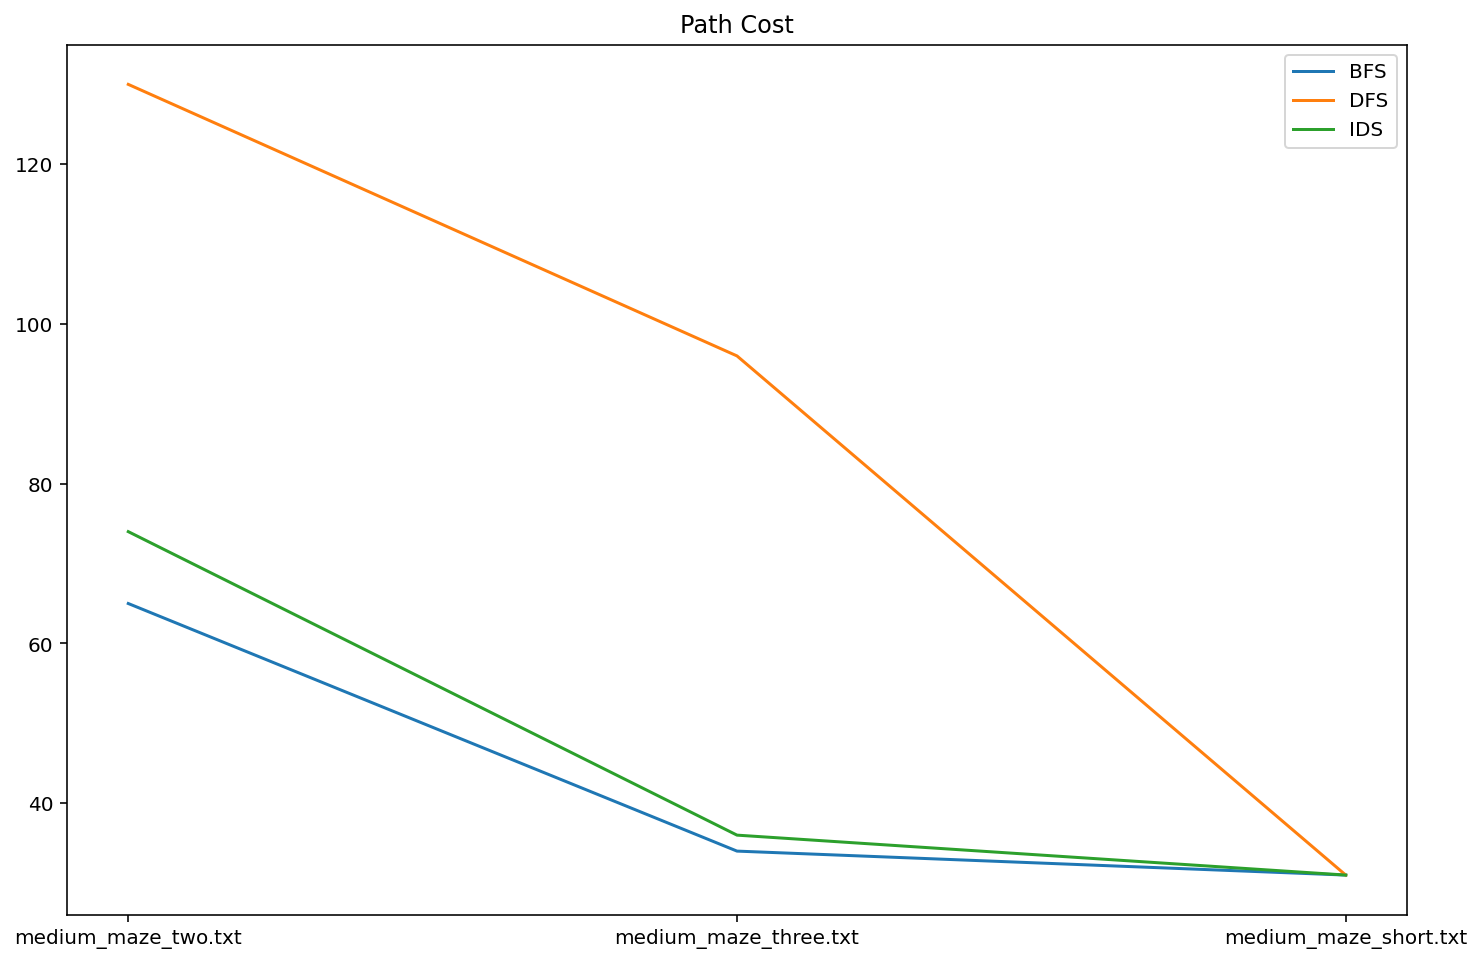

In [34]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fileNames = ["medium_maze_two.txt", "medium_maze_three.txt", "medium_maze_short.txt"]

fig = plt.figure(figsize=(12, 8))
plt.plot(fileNames, new_BFS_df["Path Cost"].to_numpy(), label='BFS')
plt.plot(fileNames, new_DFS_df["Path Cost"].to_numpy(), label='DFS')
plt.plot(fileNames, IDS_df["Path Cost"].to_numpy(), label='IDS')
plt.legend()
plt.title('Path Cost')
plt.show()


As expected, with these trials BFS always returned the optimal solution/path cost. Looking at the DFS performance, the average performance improves with multiple goal states (versus something like the regular medium maze) in the maze because it is more likely that DFS will find a solution quicker. More goal states being in the environment means a higher probability of a random DFS path being correct. One example of this improved performance was in the "medium_maze_short" maze. The DFS quickly and randomly went down the path that would not have yielded the optimal solution in the normal medium maze, but now it yielded the optimal solution. In summary, with the addition of multiple goal states, BFS still performs optimally and DFS is more likely to return an optimal solution quicker. BFS and DFS still have the same time/space complexities each with their own pros and cons (for starters, BFS large space complexity and DFS being unoptimal).

When looking at IDS, it combines some benefits of BFS and DFS together. IDS returns the same result as BFS (nearly), but  with a maximum tree depth cutoff. IDS runs by reconstructing these search trees to find the optimal solution. IDS has an uncompetitive time complexity and a long runtime. The "maximum cutoff depth" means the search algorithm has good space complexity and doesn't take up too much memory. The space compexlity of IDS is linear because each tree is deleted after its max depth is exhausted/reached. Overall, IDS returns an optimal result with a maxmimum tree depth, a competitive space complexity, and a long run time.

## More advanced tasks to think about

Instead of defining each square as a state (which you probably did), use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length in number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [35]:
# Your code/answer goes here

Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [36]:
# Your code/answer goes here

What happens if the agent does not know the layout of the maze in advance (i.e., faces an unkown, only partially observable environment)? How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [37]:
# Your code/answer goes here